In [1]:
import cupy as np
import matplotlib.pyplot as plt
import pathlib,sys,os,json
from cupy.fft import rfft2,irfft2
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
mpl.rc("text", usetex = True)

In [2]:
paramfile = '/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/parameters.json'
with open(paramfile,'r') as jsonFile: params = json.load(jsonFile)

d = params["d"] # Dimension
nu =params["nu"] # Viscosity
Re = 1/nu if nu > 0 else np.inf # Reynolds number
N = Nx = Ny = params["N"] # Grid size
dt = params["dt"] # Timestep
T = params["T"] # Final time
alph = params["alph"] # Density of the particles
eta = params["eta"]/(Nx//3) # Desired Kolmogorov length scale
Nprtcl = params["Nprtcl"] # Number of particles
st = params["st"] # Particle Stokes number
linnu = params["linnu"] # Linear viscosity

In [3]:
savePlot = pathlib.Path(f"/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/Plots/Re_{np.round(Re,2)},dt_{dt},N_{N}/")
savePlot.mkdir(parents=True, exist_ok=True)
loadPath = pathlib.Path(f"/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/data/Re_{np.round(Re,2)},dt_{dt},N_{N}/")
loadPath.exists()

True

In [4]:
Lx, Ly = (2*np.pi),(2*np.pi) #Length of the grid
X,Y = np.linspace(0,Lx,Nx,endpoint= False), np.linspace(0,Ly,Ny,endpoint= False)
dx = X[1] - X[0]
dy = Y[1] - Y[0]
x,y = np.meshgrid(X,Y,indexing="ij")

## It is best to define the function which returns the real part of the iifted function as ifft. 
ifft2 = lambda x: irfft2(x,(Nx,Ny))

## Forming the 2D grid (k space)
Kx = 2*np.pi*np.linspace(-(Nx//2) , Nx//2 - 0.5*(1+ (-1)**(Nx%2)),Nx)/Lx
Ky = 2*np.pi*np.linspace(-(Ny//2) , Ny//2 - 0.5*(1+ (-1)**(Ny%2)),Ny)/Ly
Kx = np.append(Kx[Kx>=0], Kx[Kx<0])
Ky = np.append(Ky[Ky>=0], -Ky[0])
kx,ky = np.meshgrid(Kx,Ky,indexing="ij")
## Defining the inverese laplacian.
lap = -(kx**2 + ky**2)
# lap1 = lap.copy()
# lap1[lap1== 0] = np.inf
lapinv = 1.0/np.where(lap == 0., np.inf, lap)
kx.shape

(1024, 513)

In [5]:
xi_last = np.load(loadPath/f"last/w.npy")
xi_last_r = ifft2(xi_last)
print(xi_last_r.max(),np.sqrt(np.mean(xi_last_r**2)))
u =1j* ky*lapinv*xi_last
v = -1j*kx*lapinv*xi_last
ur = ifft2(u)
vr = ifft2(v)
A = np.zeros((d,d,Nx,Ny//2+1),dtype = np.complex128)
A[0,0] = 1j*kx*u
A[0,1] = 1j*ky*u
A[1,0] = 1j*kx*v
A[1,1] = 1j*ky*v
Ar = np.zeros((d,d,Nx,Ny),dtype = np.float64)
Q = 0.0
for i in range(d):
    for j in range(d):
        Ar[i,j] = ifft2(A[i,j])
        Q += -0.5*Ar[i,j]*Ar[j,i]
Xplot,Yplot = np.linspace(0,Lx,Nx+1,endpoint= True), np.linspace(0,Ly,Ny+1,endpoint= True)
xnew = np.zeros((Nx+1,Ny+1))
Qnew = np.zeros((Nx+1,Ny+1))
xnew[1:,1:] = np.roll(xi_last_r, -1,axis = (0,1))
Qnew[1:,1:] = np.roll(Q, -1,axis = (0,1))
xnew[:-1,:-1] = xi_last_r    
Qnew[:-1,:-1] = Q

0.9667005325532964 0.32072399906606425


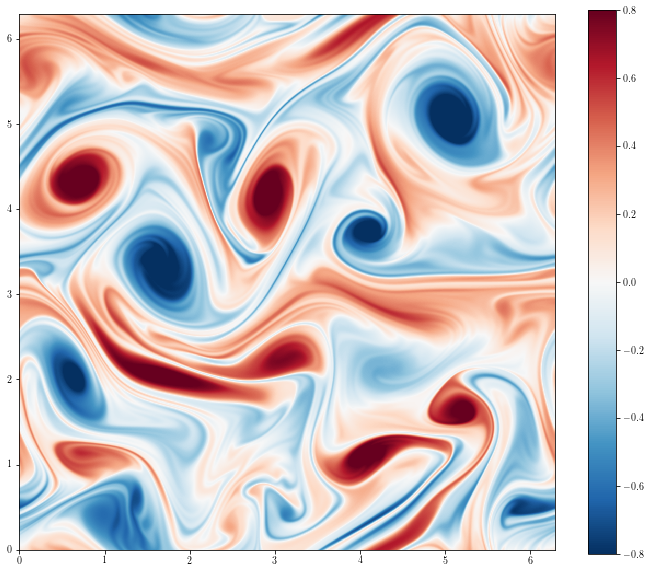

In [6]:
plt.figure(figsize=(12,10))
norm = TwoSlopeNorm(vcenter = 0,vmax = 0.2*4,vmin=-0.2*4)
p1 = plt.pcolor(Xplot.get(),Yplot.get(),(xnew.T).get(),cmap = "RdBu_r",norm = norm)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(p1)
# plt.savefig(savePlot/"xi_last_divya1.png",dpi = 300)
plt.show()
plt.close()

In [7]:
e_arr = np.load(loadPath/f"last/e_arr.npy")
kplot = np.arange(e_arr.size)
dissip = np.sum(2*(nu*kplot**2 )*(2*np.pi)**(-2.0)*e_arr )
# dissip = np.sum(2*(nu*kplot**2 )*e_arr )
eta = (nu**3/dissip)**0.25
t_k = eta**2/nu
print(t_k,eta/dx,dissip,e_arr.sum()/(2*np.pi)**2)

3.1736771463098727 0.9181242545790628 9.9282912987665e-07 0.003938461309729766


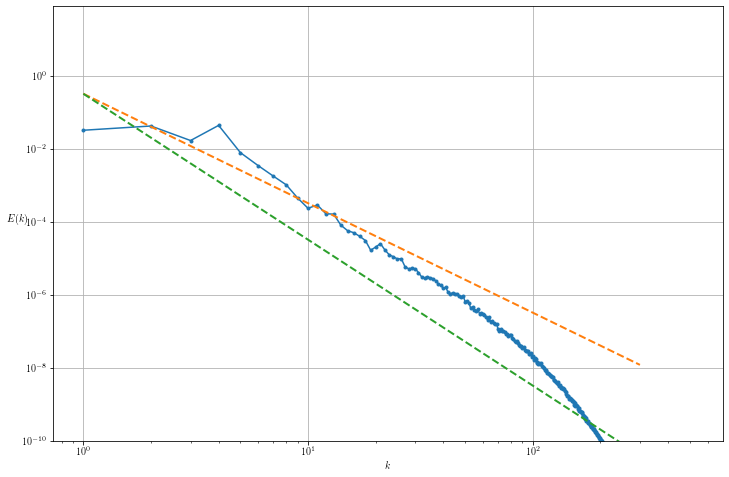

In [8]:
plt.figure(figsize=(12,8))
kplot = np.arange(e_arr.size)

plt.plot(kplot[1:].get(),(e_arr[1:]*kplot[1:]**(-0/3)).get(),'.-')
# plt.axvline(Nx//3*0.5,color = "black")
# plt.axvline(Nx//3*0.6,color = "black")
# plt.axvline(2,color = "black")
# plt.axvline(4,color = "black")
xline1 = np.array([1.,300.])
yline1 = xline1**(-9/3)
yline2 = xline1**(-12/3)
yline3 = xline1**(-5/3)
yline1[:] = yline1/yline1[0]*e_arr[1]*10
yline2[:] = yline2/yline2[0]*e_arr[1]*10
yline3[:] = yline3/yline3[0]*e_arr[1]*10
plt.plot(xline1.get(),yline1.get(),"--",linewidth = 2)
plt.plot(xline1.get(),yline2.get(),"--",linewidth = 2)
# plt.plot(xline1.get(),yline3.get(),"--",linewidth = 2)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-10,plt.ylim()[-1])
# plt.xlim(120,180)
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)$",rotation = 0)
plt.grid()
np.sum(e_arr)
plt.savefig(savePlot/"e_k_divya1.png",dpi = 300)
plt.show()
plt.close()
# print(t_k,eta*(N//3),dissip,e_arr.sum())


PiYG
PRGn
BrBG
mor
RdGy
RdBu
RdYlBu
RdYlGn
Spectral
coolwarm
bwr
seismic

In [9]:
dissip = (10*nu)**3/(3/N )**4
dissip

0.0135742176268642

In [10]:
def Linterp(pos,u_field):
# pos = np.array([[1,2]])
    xindex = (pos[:,0]//dx)%Nx
    yindex = (pos[:,1]//dy)%Ny
    xrem = pos[:,0]%dx/dx
    yrem = pos[:,1]%dy/dy

    idx1 = ((xindex+0)%Nx).astype(int)
    idx2 = ((xindex+1)%Nx).astype(int)
    idy1 = ((yindex+0)%Nx).astype(int)
    idy2 = ((yindex+1)%Nx).astype(int)
    ## Linear interpolation
    return (((1 - xrem) * (1 - yrem))[:,None] *u_field[idx1,idy1,...] + ((1 - xrem) * (yrem) )[:,None]*u_field[idx1,idy2,...] + ((xrem)*(1-yrem))[:,None]*u_field[idx2,idy1,...]  + ((xrem)*(yrem))[:,None]*u_field[idx2,idy2,...])

(1024, 513) (1024, 513)
(262144, 2) (262144,)


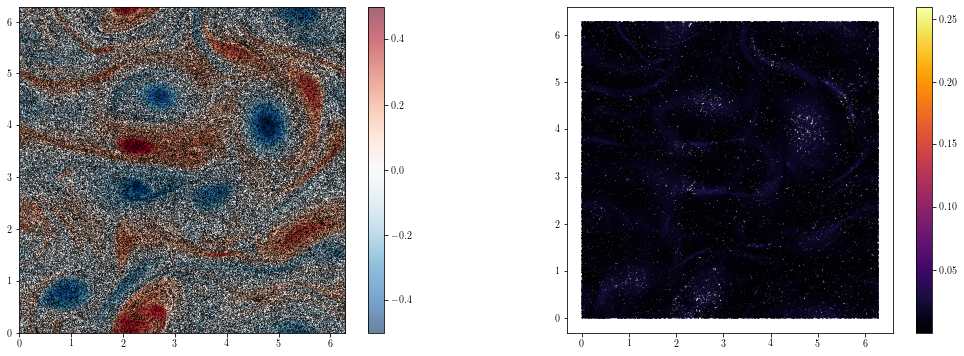

<Figure size 432x288 with 0 Axes>

In [11]:
Xplot,Yplot = np.linspace(0,Lx,Nx+1,endpoint= True), np.linspace(0,Ly,Ny+1,endpoint= True)
xnew = np.zeros((Nx+1,Ny+1))
psi = np.zeros((Nx,Ny//2+1),dtype = np.complex128)
u_field = np.zeros((Nx,Ny,2))
plt.figure(figsize = (18,6))
fig = plt.gcf()
ax = plt.gca()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)

# ax.set_facecolor('none')
# ax.patch.set_alpha(0.0)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$", rotation = 0)
for t in np.arange(100,100.1,1):
    print(t,end = '\r')
    alph = 0.67
    pos= np.load(loadPath/f"alpha_{alph:.2}_prtcl/time_{t:.2f}/pos.npy")
    vel= np.load(loadPath/f"alpha_{alph:.2}_prtcl/time_{t:.2f}/vel.npy")
    if abs(int(t) - t) < 0.01:
        xi_last = np.load(loadPath/f"time_{t:.2f}/w.npy")
        print(xi_last.shape,lapinv.shape)
        psi[:] = -xi_last*lapinv
        u_field[...,0] = ifft2(1j * ky*psi)
        u_field[...,1] = ifft2(-1j * kx*psi) 
        xi_last_r = ifft2(xi_last)
        xnew[1:,1:] = np.roll(xi_last_r, -1,axis = (0,1))
        xnew[:-1,:-1] = xi_last_r
    norm = TwoSlopeNorm(vcenter = 0,vmax = .5,vmin=-.5)
    u = Linterp(pos,u_field)
    q = np.linalg.norm(vel - u,axis = 1)/np.linalg.norm(u,axis = 1)
    print(pos.shape, q.shape)
    plt.subplot(121)
    p1 = plt.pcolor(Xplot.get(),Yplot.get(),(xnew.T).get(),cmap = "RdBu_r",norm = norm,alpha=0.6)
    plt.colorbar()
    plt.plot(pos[:,0].get(),pos[:,1].get(),'.',color='#000000',markersize  = 0.2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.subplot(122)
    p2 = plt.scatter(pos[:,0].get(),pos[:,1].get(),0.2,c=q.get(),cmap = "inferno" )
    plt.colorbar()
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.savefig(savePlot/f"alpha_{alph:.2}_time_{t:.2f}.png",dpi = 200)
    plt.show()
    plt.clf()

         

In [ ]:
t = 0.
pos1 = np.load(loadPath/f"alpha_{alph:.2}_prtcl/time_{t:.2f}/pos.npy")
t = 1.
pos2 = np.load(loadPath/f"alpha_{alph:.2}_prtcl/time_{t:.2f}/pos.npy")

In [ ]:
pos2 - pos1

array([[-0.17907508,  0.52396446],
       [-0.18084743,  0.51772197],
       [-0.18444929,  0.4748265 ],
       ...,
       [-0.18261553,  0.51559478],
       [-0.18336897, -5.76036516],
       [-0.15846465,  0.51332398]])

In [ ]:
import pstats
stats = pstats.Stats('/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/profile_2.pstats')
stats.sort_stats('tottime').print_stats(10)

Thu Jul 18 15:25:01 2024    /home/rajarshi.chattopadhyay/fluid/2DV_and_particles/profile_2.pstats

         92368634 function calls (92360802 primitive calls) in 3564.510 seconds

   Ordered by: internal time
   List reduced from 2295 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   160031 2770.866    0.017 2776.862    0.017 /home/rajarshi.chattopadhyay/mambaforge/lib/python3.10/site-packages/cupy/_statistics/histogram.py:119(_get_bin_edges)
    80005  203.888    0.003  224.686    0.003 2DV.py:181(Linterp)
    80004  122.135    0.002 3111.778    0.039 2DV.py:215(adv)
    80004  102.922    0.001  141.390    0.002 2DV.py:150(forcing)
        1   70.890   70.890 3563.580 3563.580 2DV.py:234(evolve_and_save)
   880052   33.834    0.000  120.262    0.000 /home/rajarshi.chattopadhyay/mambaforge/lib/python3.10/site-packages/cupy/fft/_fft.py:484(_exec_fftn)
   880052   25.754    0.000   25.754    0.000 {method 'fft' of 'cupy.cuda.cufft.P

In [ ]:
x = np.array([4,5,6])
max(x,4)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()